# Libraries 

In [1]:
# Libraries
import numpy as np
import scipy.linalg
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scipy.sparse.csr import csr_matrix
from scipy.sparse.extract import tril, triu
from scipy.sparse.construct import diags
import math
import time
import xlsxwriter

<center><h2>Source Code</h2></center><br>
<center><h2>Direct Method</h2></center>

## Gaussian Elimination

In [2]:
def gauss(A,b):
    n = A.shape[0]
    
    # Elimination 
    for k in range(0,n-1):
        for i in range(k+1,n):
            if A[i,k] != 0.0:
                lam = A[i,k]/A[k,k]
                A[i,k+1:n] = A[i,k+1:n] - lam * A[k,k+1:n]
                b[i] = b[i] - lam*b[k]
    
    # Back substitution
    for k in range(n-1,-1,-1):
        b[k] = (b[k] - np.dot(A[k,k+1:n], b[k+1:n]))/A[k,k]
    
    return b

## LU-Factorization Method

In [3]:
def LUdecomp(A):
    n = A.shape[0]
    for k in range(0,n-1):
        for i in range(k+1,n):
            if A[i,k] != 0.0:
                lam = A[i,k]/A[k,k]
                A[i,k+1:n] = A[i,k+1:n] - lam * A[k,k+1:n]
                A[i,k] = lam
    return A

def lu_solve(A,b):
    a = LUdecomp(A)
    n = a.shape[0]
    for k in range(1,n):
        b[k] = b[k] - np.dot(a[k,0:k], b[0:k])
    b[n-1] = b[n-1] / a[n-1,n-1]
    for k in range(n-2,-1,-1):
        b[k] = (b[k] - np.dot(a[k,k+1:n],b[k+1:n]))/a[k,k]
        
    return b



<center><h2>Testing Direct Method</h2></center>

In [4]:
# Generate random 2X2, 3X3, ..., 50x50 matrix
A, b, x_true = list(), list(), list()
nDim = 2
for i in range (31):
    A.append(np.random.randint(-100, 100, (nDim, nDim)).astype('float'))
    x_true.append(np.random.randint(-100, 100, (nDim,1)).astype('float'))
    b.append((A[i]@x_true[i]))
    nDim += 1

In [5]:
# Gaussian Method
errorG = list()
timeG = list()
resultG = list()
for i in range(31):
    start = time.time()
    resultG.append(gauss(A[i], b[i]))
    end = time.time()
    timeG.append(end-start)
    errorG.append(np.linalg.norm(x_true[i]-resultG[i]))
#     print("time gaussian = ", (i+1), timeG[i])
#     print("error gaussian = ", (i+1), errorG[i])

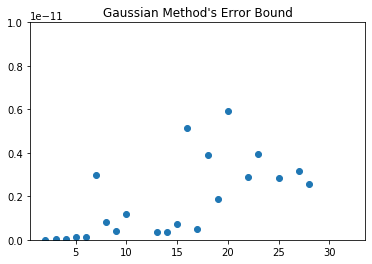

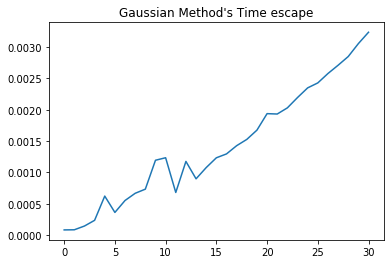

In [6]:
plt.title("Gaussian Method's Error Bound")
plt.scatter(range(2,33),errorG)
plt.ylim(0,10e-12)
plt.show()
plt.title("Gaussian Method's Time escape")
plt.plot(timeG)
plt.show()

In [7]:
# LU-Factorization Method
errorLU = list()
timeLU = list()
resultLU = list()
for i in range(31):
    start = time.time()
    resultLU.append(lu_solve(A[i],b[i]))
    end = time.time()
    timeLU.append(end-start)
    errorLU.append(np.linalg.norm(x_true[i]-resultLU[i]))
#     print("time LU = ", (i+1), timeLU[i])
#     print("error LU = ", (i+1), errorLU[i])

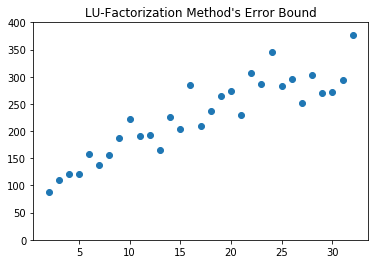

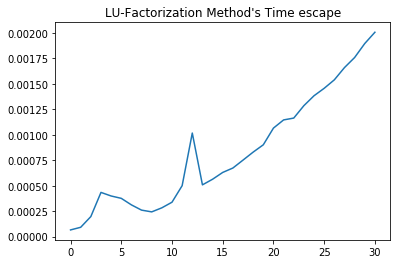

In [8]:
plt.title("LU-Factorization Method's Error Bound")
plt.scatter(range(2,33),errorLU)
plt.ylim(0,400)
plt.show()
plt.title("LU-Factorization Method's Time escape")
plt.plot(timeLU)
plt.show()

<center><h2>Source Code</h2></center><br>
<center><h2>Iterative Method</h2></center>

## Jacobi Method

In [9]:
def jacobi(A,b,x=None,numIter=10001,tol=1e-13):
    nDim = A.shape[0]
    D = csr_matrix.diagonal(A)
    L = -tril(A, k=-1)
    U = -triu(A, k=1)
    if x is None:
        x = np.zeros((numIter+1,nDim))
    for k in range(numIter):
        x[k+1] = ((L+U)@x[k])/D + b/D
#         print(np.linalg.norm(x[k+1]-x[k]))
        if np.linalg.norm(x[k+1]-x[k]) < tol:
            break
    return x[:k+1], np.linalg.norm(x[k+1]-x[k]), k


## Gauss Seidel Method 

In [10]:
def iterEqs(x, omega):
    n = len(x)
    x[0] = omega*(x[1] - x[n-1])/2.0 + (1.0 - omega)*x[0]
    for i in range(1, n-1):
        x[i] = omega*(x[i-1] + x[i+1])/2.0 + (1.0 - omega)*x[i]
    x[n-1] = omega*(1.0 - x[0] + x[n-2])/2.0 + (1.0 - omega)*x[n-1]
    return x

def gauss_seidel(iterEqs,x,tol=1.0e-9):
    omega = 1.0
    k = 10
    p = 1
    dict_dx = dict()
    for i in range(1,10001):
        xOld = x.copy()
        x = iterEqs(x,omega)
        dx = math.sqrt(np.dot(x-xOld, x-xOld))
        dict_dx = {i:dx}
        if dx < tol:
            return x, i, dict_dx
        print(dx)
        # compute relaxation factor after k+p iterations
        if i == k:
            dx1 = dx
        if i == k + p:
            dx2 = dx
            omega = 2.0/(1.0 + math.sqrt(1.0 - (dx2/dx1)**(1.0/p)))
    
    print("Gauss-Seidel failed to converge")

## Conjugate Gradient Method

In [11]:
def conjGrad(A, b, x=None, tol = 10e-8, N=100000):
    if x is None:
        x = np.zeros(len(A[0]))
        
        
    r0 = b - np.dot(A,x)
    p = r0
    
    for i in range(N):
        alpha = (np.dot(r0, r0)/np.dot(p, np.dot(A,p)))
        x = x + p * alpha
        r0 = b - np.dot(A,x)
        if(math.sqrt(np.dot(r0,r0))) < tol:
                break
        else:
            beta = -(np.dot(r0, np.dot(A,p))/np.dot(p, np.dot(A,p)))
            p = r0 + beta * p
           # print(np.linalg.norm(actual - x))
    return x

## GMRES Method

In [12]:
def GMRes(A, b, x0=None, e=10e-8, nmax_iter=100, restart=None):
    
    if x0 is None:
        x0 = np.zeros(len(A[0]))
        
    r = b - np.asarray(np.dot(A, x0)).reshape(-1)

    x = []
    q = [0] * (nmax_iter)

    x.append(r)

    q[0] = r / np.linalg.norm(r)

    h = np.zeros((nmax_iter + 1, nmax_iter))
    for k in range(nmax_iter):
        y = np.asarray(np.dot(A, q[k])).reshape(-1)

        for j in range(k):
            h[j, k] = np.dot(q[j], y)
            y = y - h[j, k] * q[j]
        h[k + 1, k] = np.linalg.norm(y)
        if (h[k + 1, k] != 0 and k != nmax_iter - 1):
            q[k + 1] = y / h[k + 1, k]

        b = np.zeros(nmax_iter + 1)
        b[0] = np.linalg.norm(r)

        result = np.linalg.lstsq(h, b)[0]

        x.append(np.dot(np.asarray(q).transpose(), result) + x0)
    return x

## <center>Testing Iterative Method</center>

## Generate random Matrix

In [13]:
def getMatrix(n=10, isDiagDom=True):
    '''
    Return an nxn matrix which is the discretization matrix
    from finite difference for a diffusion problem.
    '''
    # Representation of sparse matrix and right-hand side
    assert n >= 2
    n -= 1
    diagonal  = np.zeros(n+1)
    lower     = np.zeros(n)
    upper     = np.zeros(n)

    # Precompute sparse matrix
    if isDiagDom:
        diagonal[:] = 2 + 1/n**2
    else:
        diagonal[:] = 2
    lower[:] = -1  #1
    upper[:] = -1  #1

    
    A = diags(
        diagonals=[diagonal, lower, upper],
        offsets=[0, -1, 1], shape=(n+1, n+1),
        format='csr')

    return A

'''5x5, 20x20, 55x55'''
A1,b1,x_true1 = list(), list(),list()
nDim = [5, 20, 50]
index = 0
for i in nDim:
    A1.append(getMatrix(n=i))
    x_true1.append(np.random.randn(i))
    b1.append(A1[index]@x_true1[index])
    index += 1
    

In [14]:
# Jacobi Method 
print('Jacobi Method')
print('{', 'Iteration: Error' ,'}')
for i in range(3):
    x, error, iterr = jacobi(A1[i],b1[i])
    print(iterr,error)
#     print("="*50)

Jacobi Method
{ Iteration: Error }
167 9.9292257915e-14
2479 9.992916946302982e-14
10000 1.0196523897964225e-10


In [15]:
# Gauss Seidel Method 
print('Gauss Seidel Method')
print('{', 'Iteration: Error' ,'}')
for i in nDim:
    x,numOfIter,dx = gauss_seidel(iterEqs,x = np.zeros(i))
    print("="*50)
#     print(dx)

Gauss Seidel Method
{ Iteration: Error }
0.5
0.42990051538117513
0.3085338679291169
0.22388411908760666
0.15202058140845806
0.10531583285305707
0.07351661256953061
0.051377702192343444
0.03609392967889628
0.025498998827269043
0.01810427027847397
0.01992715361750875
0.011374496861697671
0.007776238380917692
0.005283646589761368
0.0034745298707330656
0.002151888115523954
0.0012875266712547842
0.0007616320130754284
0.00046822858088963566
0.00030905924648481773
0.00021114804898485638
0.0001420243690839683
9.122785068428766e-05
5.583138269417542e-05
3.302832451496089e-05
1.9690238300177537e-05
1.2448968373174556e-05
8.3724324564021e-06
5.714664002933119e-06
3.7853207941226265e-06
2.3878768890199433e-06
1.4377899045796365e-06
8.47769729315489e-07
5.143641523766723e-07
3.3381972994693633e-07
2.2721578904121995e-07
1.5395643673697475e-07
1.002423733188335e-07
6.205329702381377e-08
3.690978489011084e-08
2.1854639355950416e-08
1.3570320242612732e-08
9.014233940968423e-09
6.1609347379519676e-09
4

In [ ]:
# # Conjugate Gradient Method
# errorCG = list()
# timeCG = list()
# resultCG = list()
# for i in range(51):
#     start = time.time()
#     resultCG.append(conjGrad(A[i],b[i],[0]*A[i].shape[0]))
#     end = time.time()
#     timeCG.append(end-start)
#     errorCG.append(np.linalg.norm(x_true1[i]-resultCG[i]))

In [ ]:
# GMRES Method
errorGMR = list()
timeGMR = list()
for i in range(3):
    start = time.time()
    result = GMRes(A[i], b[i])
    end = time.time()
    timeGMR.append(end-start)
    exact = np.linalg.solve(A[i], b[i])
    errorGMR.append(np.linalg.norm(exact-result))

### Write it on excel

In [ ]:
workbook = xlsxwriter.Workbook('Result.xlsx')
worksheet = workbook.add_worksheet()
##########################################################################
#
##########################################################################
row = 1
column = 0
# write title
worksheet.write(0, column, "Gaussian's Error")

# iterating through content of error list of Gaussian method
for errG in errorG:
    try:
        # write operation perform
        worksheet.write(row, column, errG)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1

row = 1
column = 1
worksheet.write(0, column, "Gaussian's Time")
# iterating through content of error list of Gaussian method
for timG in timeG:
    try:
        # write operation perform
        worksheet.write(row, column, timG)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1

##########################################################################
#
##########################################################################
row = 1
column = 2

worksheet.write(0, column, "LU's Error")
# iterating through content list
for errLU in errorLU:
    try:
        # write operation perform
        worksheet.write(row, column, errLU)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1
    
row = 1
column = 3
worksheet.write(0, column, "LU's Time")
# iterating through content list
for timLU in timeLU:
    try:
        # write operation perform
        worksheet.write(row, column, timLU)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1
##########################################################################
#
##########################################################################

row = 1
column = 4
worksheet.write(0, column, "Jacobi's Error")
# iterating through content list
for errJM in errorJM:
    try:
        # write operation perform
        worksheet.write(row, column, errJM)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1
    
row = 1
column = 5
worksheet.write(0, column, "Jacobi's Time")
# iterating through content list
for timJM in timeJM:
    try:
        # write operation perform
        worksheet.write(row, column, timJM)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1
##########################################################################
#
##########################################################################

row = 1
column = 6
worksheet.write(0, column, "Gauss Seidel's Error")
# iterating through content list
for errGS in errorGS:
    try:
        # write operation perform
        worksheet.write(row, column, errGS)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1
    
row = 1
column = 7
worksheet.write(0, column, "Gauss Seidel's Time")
# iterating through content list
for timGS in timeGS:
    try:
        # write operation perform
        worksheet.write(row, column, timGS)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1

##########################################################################
#
##########################################################################

row = 1
column = 8
worksheet.write(0, column, "Conjugate Gradient's Error")
# iterating through content list
for errCG in errorCG:
    try:
        # write operation perform
        worksheet.write(row, column, errCG)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1
    
row = 1
column = 9
worksheet.write(0, column, "Conjugate Gradient's Time")
# iterating through content list
for timCG in timeCG:
    try:
        # write operation perform
        worksheet.write(row, column, timCG)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1

##########################################################################
#
##########################################################################

row = 1
column = 10
worksheet.write(0, column, "GMRES's Error")
# iterating through content list
for errGMR in errorGMR:
    try:
        # write operation perform
        worksheet.write(row, column, errGMR)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1
    
row = 1
column = 11
worksheet.write(0, column, "GMRES's Time")
# iterating through content list
for timGMR in timeGMR:
    try:
        # write operation perform
        worksheet.write(row, column, timGMR)
    except:
        pass
    # incrementing the value of row by one
    # with each iteratons.
    row += 1

##########################################################################
#
##########################################################################

workbook.close()